# Spatial Distance analysis for figure 4
**Goal:**  Plot for figure 4
**Input:** Merged adata from 991 and 992    
**Output:** Plots of interactions between cells
**Author:** Jose Nimo    
**Date_of_creation:** 19.05.2025     
**Date_of_latest_modification:** 19.05.2025    
**Status:** In Progress

# Setup and Imports

In [2]:
import os,sys,time
from loguru import logger 

# import scimap as sm

import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import anndata as ad

import pyarrow
import ast

#plotting
import matplotlib.pyplot as plt
import seaborn as sns

#custom functions
sys.path.append(os.path.abspath('/Users/jnimoca/Jose_BI/1_Pipelines/openDVP/src/'))
# from opendvp import anndata_utils, filtering, imaging, utils
# with updated opendvp it requires spatialdata, will keep this in mind
import importlib

for package in [np,pd,gpd,ad]:
    print(f"{package.__name__} {package.__version__}")

numpy 2.2.4
pandas 2.2.3
geopandas 1.0.1
anndata 0.10.9


In [86]:
adata = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_distance', 'spatial_interaction_radius', 'spatial_interaction_radius_perimage', 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn

## Plot 1: boxenplots side by side with t-test

### get data

In [ ]:
# x-axis = distance
# y-axis = phenotype

In [5]:
adata.uns['spatial_distance']

,Cancer_cells,CD4_Tcells,CD8_Tcells,COL1A1_cells,Unknown,Vimentin_cells,B_cells,Macrophages
0,33.367705,136.137931,837.229589,669.043495,193.964022,713.136101,1402.672770,4088.148866
1,56.731864,53.390938,1080.481594,472.813804,384.873975,1001.665356,1648.138556,3837.274906
2,28.488148,127.598767,1789.450622,107.674763,200.244535,1110.677455,2804.812172,2029.743317
3,27.430906,40.724135,462.691563,60.341981,23.272106,178.534699,1088.763931,4894.472866
4,41.610681,187.027724,806.790392,204.695488,218.685279,639.052788,2445.118711,3583.559453
...,...,...,...,...,...,...,...,...
1134342,33.964702,78.114542,1190.802765,211.237266,30.165217,475.359402,1437.166880,439.094881
1134343,30.841049,87.714084,1030.504874,336.486849,58.007720,484.190958,1979.178482,375.140005
1134344,47.378595,147.940585,1072.534903,104.650835,24.653402,516.487521,1435.419967,353.370607
1134345,26.772239,50.871706,983.200071,211.527435,158.642792,326.297679,1611.401565,149.553658


In [ ]:
# it seems these distances include both slides, this is a mistake
# load 991 data, then measure distance
# checked processing notebook, it measures spatial distance one image at a time
# ok, but then I filter rows per imageid, use index

In [87]:
dist = adata.uns['spatial_distance'].copy()
dist

,Cancer_cells,CD4_Tcells,CD8_Tcells,COL1A1_cells,Unknown,Vimentin_cells,B_cells,Macrophages
0,33.367705,136.137931,837.229589,669.043495,193.964022,713.136101,1402.672770,4088.148866
1,56.731864,53.390938,1080.481594,472.813804,384.873975,1001.665356,1648.138556,3837.274906
2,28.488148,127.598767,1789.450622,107.674763,200.244535,1110.677455,2804.812172,2029.743317
3,27.430906,40.724135,462.691563,60.341981,23.272106,178.534699,1088.763931,4894.472866
4,41.610681,187.027724,806.790392,204.695488,218.685279,639.052788,2445.118711,3583.559453
...,...,...,...,...,...,...,...,...
1134342,33.964702,78.114542,1190.802765,211.237266,30.165217,475.359402,1437.166880,439.094881
1134343,30.841049,87.714084,1030.504874,336.486849,58.007720,484.190958,1979.178482,375.140005
1134344,47.378595,147.940585,1072.534903,104.650835,24.653402,516.487521,1435.419967,353.370607
1134345,26.772239,50.871706,983.200071,211.527435,158.642792,326.297679,1611.401565,149.553658


In [88]:
dist_991 = dist.loc[adata.obs[adata.obs['imageid']==991].index,:].copy()
dist_992 = dist.loc[adata.obs[adata.obs['imageid']==992].index,:].copy()

In [89]:
dist_991_melted = dist_991.melt()
dist_991_melted['imageid'] = 991

dist_992_melted = dist_992.melt()
dist_992_melted['imageid'] = 992

In [90]:
dists = pd.concat([dist_991_melted, dist_992_melted])

In [91]:
dists

,variable,value,imageid
0,Cancer_cells,33.367705,991
1,Cancer_cells,56.731864,991
2,Cancer_cells,28.488148,991
3,Cancer_cells,27.430906,991
4,Cancer_cells,41.610681,991
...,...,...,...
8040403,Macrophages,439.094881,992
8040404,Macrophages,375.140005,992
8040405,Macrophages,353.370607,992
8040406,Macrophages,149.553658,992


<Axes: xlabel='value', ylabel='variable'>

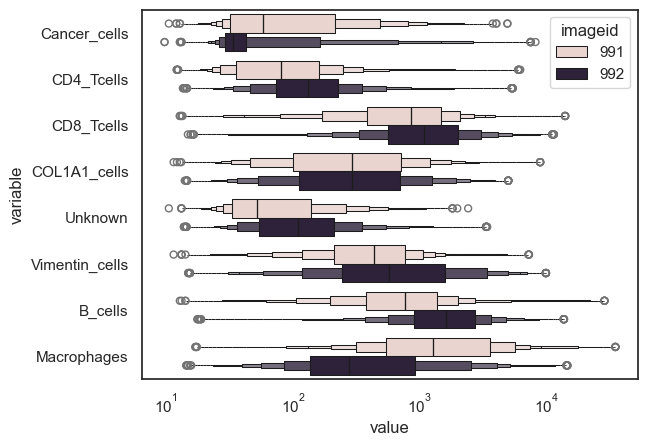

In [92]:
sns.boxenplot(dists, x="value", y="variable", hue="imageid", log_scale=True )

In [26]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

def compare_groups(df, group_col, category_col, value_col):
    """
    Performs t-test and Mann-Whitney U test for each category in category_col,
    comparing the two groups in group_col based on value_col.
    
    Parameters:
        df (pd.DataFrame): Data in long format.
        group_col (str): Column name with two categorical groups (e.g., "A", "B").
        category_col (str): Column name with categories to test separately.
        value_col (str): Column name with numerical values (e.g., log-transformed data).
    
    Returns:
        pd.DataFrame: Results with columns for category, test statistics, and p-values.
    """
    results = []

    categories = df[category_col].unique()
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("group_col must contain exactly two groups.")

    group1, group2 = groups

    for cat in categories:
        subset = df[df[category_col] == cat]
        vals1 = subset[subset[group_col] == group1][value_col].dropna()
        vals2 = subset[subset[group_col] == group2][value_col].dropna()

        if len(vals1) < 2 or len(vals2) < 2:
            continue  # skip tests if not enough data

        # T-test
        t_stat, t_pval = ttest_ind(vals1, vals2, equal_var=False)

        # Mann-Whitney U test
        u_stat, u_pval = mannwhitneyu(vals1, vals2, alternative="two-sided")

        results.append({
            category_col: cat,
            't_statistic': t_stat,
            't_pvalue': t_pval,
            'u_statistic': u_stat,
            'u_pvalue': u_pval,
            'n_group1': len(vals1),
            'n_group2': len(vals2)
        })

    return pd.DataFrame(results)


In [27]:
results = compare_groups(df=dists, group_col="imageid", category_col="variable", value_col="value")

In [85]:
results

NameError: name 'results' is not defined

In [93]:
mean_diffs = dists.groupby(["imageid", "variable"]).mean()
mean_diffs

value
imageid variable                   
991     B_cells         1359.221887
        CD4_Tcells       153.320969
        CD8_Tcells      1095.578864
        COL1A1_cells     547.214098
        Cancer_cells     204.804543
        Macrophages     2677.831147
        Unknown          122.990193
        Vimentin_cells   563.715556
992     B_cells         2050.098331
        CD4_Tcells       212.466782
        CD8_Tcells      1534.994052
        COL1A1_cells     557.401670
        Cancer_cells     179.855158
        Macrophages      960.179107
        Unknown          193.960015
        Vimentin_cells  1311.348749

In [94]:
mean_diffs = mean_diffs.unstack().T.reset_index()
mean_diffs

imageid,level_0,variable,991,992
0,value,B_cells,1359.221887,2050.098331
1,value,CD4_Tcells,153.320969,212.466782
2,value,CD8_Tcells,1095.578864,1534.994052
3,value,COL1A1_cells,547.214098,557.401670
4,value,Cancer_cells,204.804543,179.855158
5,value,Macrophages,2677.831147,960.179107
6,value,Unknown,122.990193,193.960015
7,value,Vimentin_cells,563.715556,1311.348749


In [95]:
mean_diffs['diff'] = abs(mean_diffs[991] - mean_diffs[992])
mean_diffs.sort_values(by="diff")

imageid,level_0,variable,991,992,diff
3,value,COL1A1_cells,547.214098,557.401670,10.187571
4,value,Cancer_cells,204.804543,179.855158,24.949385
1,value,CD4_Tcells,153.320969,212.466782,59.145813
6,value,Unknown,122.990193,193.960015,70.969822
2,value,CD8_Tcells,1095.578864,1534.994052,439.415188
0,value,B_cells,1359.221887,2050.098331,690.876443
7,value,Vimentin_cells,563.715556,1311.348749,747.633193
5,value,Macrophages,2677.831147,960.179107,1717.652040


In [96]:
pheno_order = mean_diffs.sort_values(by="diff")['variable'].values
pheno_order

array(['COL1A1_cells', 'Cancer_cells', 'CD4_Tcells', 'Unknown',
       'CD8_Tcells', 'B_cells', 'Vimentin_cells', 'Macrophages'],
      dtype=object)

In [101]:
def export_figure(fig, path, suffix, dpi=600):
    os.makedirs(path, exist_ok=True)

    matplotlib = plt
    # Ensure editable text in SVG
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    matplotlib.rcParams['font.family'] = 'Open Sans'
    matplotlib.rcParams['font.size'] = 14
    matplotlib.rcParams['svg.fonttype'] = 'none'

    datetime_str = time.strftime("%Y%m%d_%H%M")
    base_filename = f"{datetime_str}_{suffix}"

    pdf_path = os.path.join(path, f"{base_filename}.pdf")
    svg_path = os.path.join(path, f"{base_filename}.svg")

    fig.savefig(fname=pdf_path, format="pdf", dpi=dpi, bbox_inches="tight")
    fig.savefig(fname=svg_path, format="svg", dpi=dpi, bbox_inches="tight", transparent=True)

    print(f"Figure saved as: {pdf_path} and {svg_path}")

In [107]:
dists

,variable,value,imageid
0,Cancer_cells,33.367705,991
1,Cancer_cells,56.731864,991
2,Cancer_cells,28.488148,991
3,Cancer_cells,27.430906,991
4,Cancer_cells,41.610681,991
...,...,...,...
8040403,Macrophages,439.094881,992
8040404,Macrophages,375.140005,992
8040405,Macrophages,353.370607,992
8040406,Macrophages,149.553658,992


In [120]:
new_order = pheno_order.tolist()
new_order.remove("Unknown")

In [121]:
new_order

['COL1A1_cells',
 'Cancer_cells',
 'CD4_Tcells',
 'CD8_Tcells',
 'B_cells',
 'Vimentin_cells',
 'Macrophages']

In [122]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(10,10))
sns.boxenplot(
    dists[dists['variable']!="Unknown"], 
    x="value", y="variable", hue="imageid", 
    log_scale=True, palette="tab10", order=new_order,ax=ax, linewidth=1, showfliers=False)

# ax.set_xticks(range(len(ax.get_xticklabels())))
# ax.set_xticklabels([tick.get_text() for tick in ax.get_xticklabels()])

# Add vertical gridlines at each xtick
ax.xaxis.grid(True)  # Enable gridlines for the x-axis
# ax.yaxis.grid(True)  # Optionally, keep y-axis gridlines too

export_figure(fig, path="../figures/distance_boxenplots/", suffix="boxenplots_distance_to_cancer", dpi=600)

findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: Font family 'Open Sans' not found.
findfont: 

Figure saved as: ../figures/distance_boxenplots/20250519_1455_boxenplots_distance_to_cancer.pdf and ../figures/distance_boxenplots/20250519_1455_boxenplots_distance_to_cancer.svg


In [68]:
adata

AnnData object with n_obs × n_vars = 1615233 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', 'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7', 'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7', 'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7', 'spatial_lda_knn50_kmeans_k7'
    uns: 'spatial_distance', 'spatial_interaction_radius', 'spatial_interaction_radius_perimage', 'spatial_lda_knn14', 'spatial_lda_knn14_probability', 'spatial_lda_knn21', 'spatial_lda_knn21_probability', 'spatial_lda_knn30', 'spatial_lda_knn30_probability', 'spatial_lda_knn40', 'spatial_lda_knn40_probability', 'spatial_lda_knn50', 'spatial_lda_knn50_probability', 'spatial_lda_knn7', 'spatial_lda_knn

In [70]:
!mamba list | grep numba

numba                     0.58.1                   pypi_0    pypi


In [71]:
!mamba list | grep numpy

numpy                     1.26.4                   pypi_0    pypi
numpydoc                  1.8.0                    pypi_0    pypi


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_v2/lib/python3.10/site-packages/scipy/stats/_stats_py.py:8980: RuntimeWarning: divide by zero encountered in log
  statistic = -2 * xp.sum(xp.log(pvalues), axis=axis)


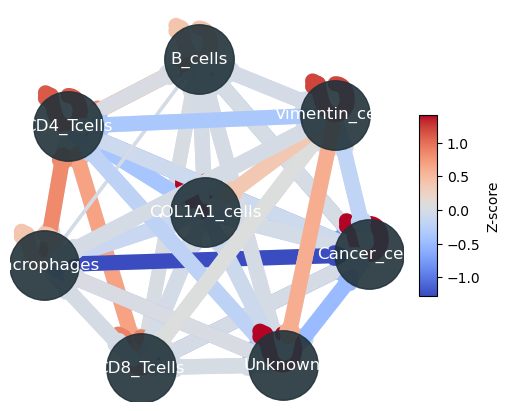

In [10]:
spatialInteractionNetwork(adata, 
                          spatial_interaction='spatial_interaction_radius', figsize=(5,4), cmap="coolwarm")

In [18]:
import numpy as np
import networkx as nx
from scipy.stats import combine_pvalues

def build_interaction_graph(dataframe, p_val=0.05):

    df = dataframe.copy()

    # Identify z-score and p-value columns
    z_score_columns = [c for c in df.columns if 'pvalue_' not in c and c not in ['phenotype', 'neighbour_phenotype']]
    p_value_columns = [c for c in df.columns if 'pvalue_' in c]

    # Combine z-scores using Stouffer's method
    df['combined_z'] = df[z_score_columns].apply(lambda z: np.sum(z) / np.sqrt(len(z)), axis=1)

    # Combine p-values using Fisher’s method
    def combine(row):
        pvals = np.array(row[p_value_columns], dtype=float)
        pvals = pvals[~np.isnan(pvals)]
        return combine_pvalues(pvals)[1] if len(pvals) else np.nan

    df['combined_p'] = df.apply(combine, axis=1)

    df = df[df['combined_p'] < p_val]

    G = nx.from_pandas_edgelist(
        df,
        'phenotype',
        'neighbour_phenotype',
        edge_attr=['combined_z', 'combined_p'],
        create_using=nx.DiGraph()
    )
    return G

In [20]:
import numpy as np
import pandas as pd
import networkx as nx
from collections import Counter
from scipy.stats import norm

def build_interaction_graph_from_distances(df, distance_threshold=20, min_count=5):
    """
    Build a directed interaction graph from cell-to-cell-type minimum distance matrix.

    Parameters:
    - df: DataFrame with columns:
        - 'phenotype': the cell type of each row (cell)
        - other columns: cell types, with values = min distance to any cell of that type
    - distance_threshold: float, distance under which cells are considered interacting
    - min_count: int, minimum number of interactions required to draw an edge

    Returns:
    - NetworkX DiGraph with edge weights = number of interactions
    """

    df = df.copy()
    celltypes = [c for c in df.columns if c != 'phenotype']

    # Step 1: For each row (cell), get target cell types that are within the threshold
    interaction_pairs = []

    for _, row in df.iterrows():
        source = row['phenotype']
        for target in celltypes:
            if row[target] < distance_threshold:
                interaction_pairs.append((source, target))

    # Step 2: Count interactions
    pair_counts = Counter(interaction_pairs)

    # Step 3: Build graph
    G = nx.DiGraph()
    for (source, target), count in pair_counts.items():
        if count >= min_count:
            G.add_edge(source, target, weight=count)

    return G


In [21]:
dist = adata.uns['spatial_distance'].copy()
dist_991 = dist.loc[adata.obs[adata.obs['imageid']==991].index,:].copy()
dist_992 = dist.loc[adata.obs[adata.obs['imageid']==992].index,:].copy()

In [22]:
G_991 = build_interaction_graph_from_distances(dist_991)

KeyError: 'phenotype'

# try per sample

In [23]:
#991
adata = ad.read_h5ad("../data/perSample/991/adata_checkpoints/7_adata_pheno/20250302_1823_7_adata_pheno_adata.h5ad")

In [26]:
# Import library
import pandas as pd
from sklearn.neighbors import BallTree
import numpy as np
from joblib import Parallel, delayed
import scipy
from functools import reduce


In [24]:
def spatial_interaction (adata,
                         x_coordinate='X_centroid',
                         y_coordinate='Y_centroid',
                         z_coordinate=None,
                         phenotype='phenotype',
                         method='radius', 
                         radius=30, 
                         knn=10,
                         permutation=1000,
                         imageid='imageid',
                         subset=None,
                         pval_method='zscore',
                         verbose=True,
                         label='spatial_interaction'):
    """
Parameters:
        adata (anndata.AnnData):  
            Annotated data matrix or path to an AnnData object, containing spatial gene expression data.

        x_coordinate (str, required):  
            Column name in `adata` for the x-coordinates.

        y_coordinate (str, required):  
            Column name in `adata` for the y-coordinates.

        z_coordinate (str, optional):  
            Column name in `adata` for the z-coordinates, for 3D spatial data analysis.

        phenotype (str, required):  
            Column name in `adata` indicating cell phenotype or any categorical cell classification.

        method (str, optional):  
            Method to define neighborhoods: 'radius' for fixed distance, 'knn' for K nearest neighbors.

        radius (int, optional):  
            Radius for neighborhood definition (applies when method='radius').

        knn (int, optional):  
            Number of nearest neighbors to consider (applies when method='knn').

        permutation (int, optional):  
            Number of permutations for p-value calculation.

        imageid (str, required):  
            Column name in `adata` for image identifiers, useful for analysis within specific images.

        subset (str, optional):  
            Specific image identifier for targeted analysis.

        pval_method (str, optional):  
            Method for p-value calculation: 'abs' for absolute difference, 'zscore' for z-score based significance.

        verbose (bool):  
            If set to `True`, the function will print detailed messages about its progress and the steps being executed.

        label (str, optional):  
            Custom label for storing results in `adata.obs`.

Returns:
        adata (anndata.AnnData):  
            Updated `adata` object with spatial interaction results in `adata.obs[label]`.

Example:
        ```python

        # Radius method for 2D data with absolute p-value calculation
        adata = sm.tl.spatial_interaction(adata, x_coordinate='X_centroid', y_coordinate='Y_centroid',
                                    method='radius', radius=50, permutation=1000, pval_method='abs',
                                    label='interaction_radius_abs')

        # KNN method for 2D data with z-score based p-value calculation
        adata = sm.tl.spatial_interaction(adata, x_coordinate='X_centroid', y_coordinate='Y_centroid',
                                    method='knn', knn=15, permutation=1000, pval_method='zscore',
                                    label='interaction_knn_zscore')

        # Radius method for 3D data analysis
        adata = sm.tl.spatial_interaction(adata, x_coordinate='X_centroid', y_coordinate='Y_centroid',
                                    z_coordinate='Z_centroid', method='radius', radius=60, permutation=1000,
                                    pval_method='zscore', label='interaction_3D_zscore')

        ```
    """


    def spatial_interaction_internal (adata_subset,x_coordinate,y_coordinate,
                                      z_coordinate,
                                      phenotype,
                                      method, radius, knn,
                                      permutation, 
                                      imageid,subset,
                                      pval_method):
        if verbose:
            print("Processing Image: " + str(adata_subset.obs[imageid].unique()))

        # Create a dataFrame with the necessary inforamtion
        if z_coordinate is not None:
            if verbose:
                print("Including Z -axis")
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'z': adata_subset.obs[z_coordinate], 'phenotype': adata_subset.obs[phenotype]})
        else:
            data = pd.DataFrame({'x': adata_subset.obs[x_coordinate], 'y': adata_subset.obs[y_coordinate], 'phenotype': adata_subset.obs[phenotype]})


        # Identify neighbourhoods based on the method used
        # a) KNN method
        if method == 'knn':
            if verbose:
                print("Identifying the " + str(knn) + " nearest neighbours for every cell")
            if z_coordinate is not None:
                tree = BallTree(data[['x','y','z']], leaf_size= 2)
                ind = tree.query(data[['x','y','z']], k=knn, return_distance= False)
            else:
                tree = BallTree(data[['x','y']], leaf_size= 2)
                ind = tree.query(data[['x','y']], k=knn, return_distance= False)
            neighbours = pd.DataFrame(ind.tolist(), index = data.index) # neighbour DF
            neighbours.drop(0, axis=1, inplace=True) # Remove self neighbour

        # b) Local radius method
        if method == 'radius':
            if verbose:
                print("Identifying neighbours within " + str(radius) + " pixels of every cell")
            if z_coordinate is not None:
                kdt = BallTree(data[['x','y','z']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y','z']], r=radius, return_distance=False)
            else:
                kdt = BallTree(data[['x','y']], metric='euclidean') 
                ind = kdt.query_radius(data[['x','y']], r=radius, return_distance=False)

            for i in range(0, len(ind)): ind[i] = np.delete(ind[i], np.argwhere(ind[i] == i))#remove self
            neighbours = pd.DataFrame(ind.tolist(), index = data.index) # neighbour DF

        # Map Phenotypes to Neighbours
        # Loop through (all functionized methods were very slow)
        phenomap = dict(zip(list(range(len(ind))), data['phenotype'])) # Used for mapping
        if verbose:
            print("Mapping phenotype to neighbors")
        for i in neighbours.columns:
            neighbours[i] = neighbours[i].dropna().map(phenomap, na_action='ignore')

        # Drop NA
        neighbours = neighbours.dropna(how='all')

        # Collapse all the neighbours into a single column
        n = pd.DataFrame(neighbours.stack(), columns = ["neighbour_phenotype"])
        n.index = n.index.get_level_values(0) # Drop the multi index

        # Merge with real phenotype
        n = n.merge(data['phenotype'], how='inner', left_index=True, right_index=True)

        # Permutation
        if verbose:
            print('Performing '+ str(permutation) + ' permutations')

        def permutation_pval (data):
            data = data.assign(neighbour_phenotype=np.random.permutation(data['neighbour_phenotype']))
            #data['neighbour_phenotype'] = np.random.permutation(data['neighbour_phenotype'])
            data_freq = data.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack()
            data_freq = data_freq.fillna(0).stack().values 
            return data_freq

        # Apply function
        final_scores = Parallel(n_jobs=-1)(delayed(permutation_pval)(data=n) for i in range(permutation)) 
        perm = pd.DataFrame(final_scores).T

        # Consolidate the permutation results
        if verbose:
            print('Consolidating the permutation results')
        # Calculate P value
        # real
        n_freq = n.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack().fillna(0).stack() 
        # permutation
        mean = perm.mean(axis=1)
        std = perm.std(axis=1)
        # P-value calculation
        if pval_method == 'abs':
            # real value - prem value / no of perm 
            p_values = abs(n_freq.values - mean) / (permutation+1)
            p_values = p_values[~np.isnan(p_values)].values
        if pval_method == 'zscore':
            z_scores = (n_freq.values - mean) / std        
            z_scores[np.isnan(z_scores)] = 0
            p_values = scipy.stats.norm.sf(abs(z_scores))*2
            p_values = p_values[~np.isnan(p_values)]

        # Compute Direction of interaction (interaction or avoidance)
        direction = ((n_freq.values - mean) / abs(n_freq.values - mean)).fillna(1)

        # Normalize based on total cell count
        k = n.groupby(['phenotype','neighbour_phenotype'],observed=False).size().unstack().fillna(0)
        # add neighbour phenotype that are not present to make k a square matrix
        columns_to_add = dict.fromkeys(np.setdiff1d(k.index,k.columns), 0)
        k = k.assign(**columns_to_add)

        total_cell_count = data['phenotype'].value_counts()
        total_cell_count = total_cell_count[k.columns].values # keep only cell types that are present in the column of k
        # total_cell_count = total_cell_count.reindex(k.columns).values # replaced by above
        k_max = k.div(total_cell_count, axis = 0)
        k_max = k_max.div(k_max.max(axis=1), axis=0).stack()

        # DataFrame with the neighbour frequency and P values
        count = (k_max.values * direction).values # adding directionallity to interaction
        neighbours = pd.DataFrame({'count': count,'p_val': p_values}, index = k_max.index)
        #neighbours.loc[neighbours[neighbours['p_val'] > p_val].index,'count'] = np.NaN
        #del neighbours['p_val']
        neighbours.columns = [adata_subset.obs[imageid].unique()[0], 'pvalue_' + str(adata_subset.obs[imageid].unique()[0])]
        neighbours = neighbours.reset_index()
        #neighbours = neighbours['count'].unstack()

        # return
        return neighbours


    # subset a particular subset of cells if the user wants else break the adata into list of anndata objects
    if subset is not None:
        adata_list = [adata[adata.obs[imageid] == subset]]
    else:
        adata_list = [adata[adata.obs[imageid] == i] for i in adata.obs[imageid].unique()]


    # Apply function to all images and create a master dataframe
    # Create lamda function 
    r_spatial_interaction_internal = lambda x: spatial_interaction_internal (adata_subset=x, x_coordinate=x_coordinate, y_coordinate=y_coordinate, 
                                                                             z_coordinate=z_coordinate, phenotype=phenotype, method=method,  radius=radius, knn=knn, permutation=permutation, imageid=imageid,subset=subset,pval_method=pval_method) 
    all_data = list(map(r_spatial_interaction_internal, adata_list)) # Apply function 


    # Merge all the results into a single dataframe    
    df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['phenotype', 'neighbour_phenotype'], how='outer'), all_data)


    # Add to anndata
    adata.uns[label] = df_merged

    # return
    return adata

In [27]:
adata = spatial_interaction (adata, 
                                  method='radius', 
                                  radius=70, 
                                  label='spatial_interaction_radius')

Processing Image: [991]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


In [31]:
adata

AnnData object with n_obs × n_vars = 610182 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', '991', 'artefact', 'mean_DAPI_bg_above_100', 'mean_DAPI_bg_below_3162', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates', 'spatial_interaction_radius'
    layers: 'log'

In [29]:
# Libs
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import anndata as ad
from scipy.stats import combine_pvalues
import matplotlib.pyplot as plt
import os

plt.rcParams['pdf.fonttype'] = 42

In [44]:
adata.uns["spatial_interaction_knn30"]

,phenotype,neighbour_phenotype,991,pvalue_991
0,B_cells,B_cells,0.463056,0.000000e+00
1,B_cells,CD4_Tcells,1.000000,0.000000e+00
2,B_cells,CD8_Tcells,0.036661,4.749480e-09
3,B_cells,COL1A1_cells,-0.066191,0.000000e+00
4,B_cells,Cancer_cells,-0.069888,0.000000e+00
...,...,...,...,...
59,Vimentin_cells,COL1A1_cells,0.266284,0.000000e+00
60,Vimentin_cells,Cancer_cells,-0.110534,0.000000e+00
61,Vimentin_cells,Macrophages,-0.000504,6.937678e-58
62,Vimentin_cells,Unknown,1.000000,0.000000e+00


<Axes: xlabel='phenotype', ylabel='991'>

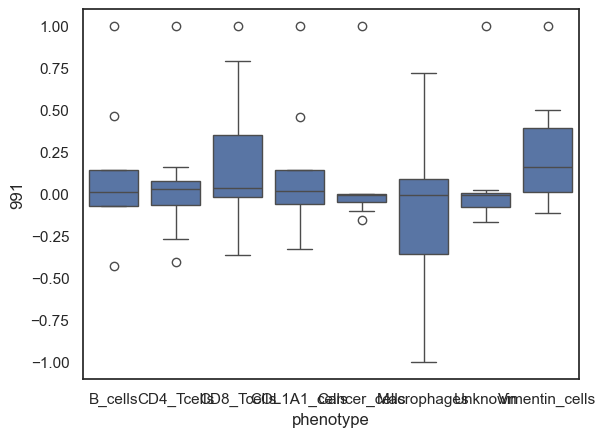

In [47]:
import seaborn as sns
sns.boxplot(
    adata.uns["spatial_interaction_knn30"], 
    x="phenotype",
    y="991"
    )

In [ ]:
def spatialInteractionNetwork(
    adata,
    spatial_interaction='spatial_interaction',
    p_val=0.05,
    cmap='vlag',
    nodeColor='#22333b',
    nodeSize=None,
    alpha=0.9,
    figsize=None,
    fontSize=12,
    fontColor='white',
    subsetPhenotype=None,
    fileName='spatialInteractionNetwork.pdf',
    saveDir=None,
):
    """
    Parameters:
        adata (AnnData or str):
            An AnnData object or a path to an .h5ad file containing the dataset.

        spatial_interaction (str):
            Key in `adata.uns` for spatial interaction data.

        p_val (float):
            Threshold for significance of interactions to display.

        cmap (str):
            Colormap for the edges based on their z-scores.

        nodeColor (str):
            Color of the nodes.

        nodeSize (int or None):
            Size of the nodes. If None, size is dynamically adjusted.

        alpha (float):
            Opacity of the nodes.

        figsize (tuple or None):
            Figure size as (width, height). If None, size is dynamically calculated.

        fontSize (int):
            Font size for node labels.

        fontColor (str):
            Color of the node labels.

        subsetPhenotype (list of str or None):
            List of phenotypes to include. If None, all are included.

        fileName (str):
            Filename for saving the network plot.

        saveDir (str or None):
            Directory to save the plot file. If None, plot is shown and not saved.

    Returns:
            plot (matplotlib):
                Displays or saves a network plot visualizing the interactions between cell types.

    Example:
        ```python

        # Visualizes the network using the 'coolwarm' colormap.
        sm.pl.spatialInteractionNetwork(adata, cmap='coolwarm')

        # Filters for 'T cells' and 'B cells' interactions, saves the visualization as 'T_B_interaction.pdf' in './plots'.
        sm.pl.spatialInteractionNetwork(adata, subsetPhenotype=['T cells', 'B cells'], fileName='T_B_interaction.pdf', saveDir='./plots')
        ```
    """

    # Load adata if a path is provided
    if isinstance(adata, str):
        adata = ad.read_h5ad(adata)

    # create a copy of the distance measurement
    if spatial_interaction not in adata.uns:
        raise KeyError(
            f"{spatial_interaction} does not exist in adata.uns. Please check if the '{spatial_interaction}' column exists or run `sm.tl.spatial_interaction(adata)` to compute it."
        )

    # copy the data to plot
    df = adata.uns[spatial_interaction].copy()

    # subset
    if subsetPhenotype:
        if isinstance(subsetPhenotype, str):
            subsetPhenotype = [subsetPhenotype]
        df = df[
            df['phenotype'].isin(subsetPhenotype)
            & df['neighbour_phenotype'].isin(subsetPhenotype)
        ]
        # Convert to categorical if not already
        df['phenotype'] = df['phenotype'].astype('str').astype('category')
        df['neighbour_phenotype'] = (
            df['neighbour_phenotype'].astype('str').astype('category')
        )

    # now calculate a meta score across images
    # Automatically identify z-score and p-value columns
    z_score_columns = [
        col
        for col in df.columns
        if 'pvalue_' not in col and col not in ['phenotype', 'neighbour_phenotype']
    ]
    p_value_columns = [col for col in df.columns if 'pvalue_' in col]

    # Ensure there is a matching p-value column for each z-score column
    assert len(z_score_columns) == len(
        p_value_columns
    ), "The number of z-score columns does not match the number of p-value columns."

    def stouffers_method(z_scores):
        """Combines z-scores using Stouffer's method."""
        combined_z = np.sum(z_scores) / np.sqrt(len(z_scores))
        return combined_z

    def combine_z_scores(row):
        """Extracts and combines z-scores from the row."""
        z_scores = row[z_score_columns].values
        combined_z = stouffers_method(z_scores)
        return combined_z

    def combine_p_values(row, p_value_columns):
        """Extracts p-values from the row and combines them using Fisher's method."""
        p_values = [
            row[col] for col in p_value_columns
        ]  # Extract p-values for the specified columns

        # Convert to a NumPy array and ensure type float for NaN handling
        p_values_array = np.array(p_values, dtype=float)

        # Filter out NaN values before combining
        p_values_filtered = p_values_array[~np.isnan(p_values_array)]

        # Check if filtered array is empty
        if p_values_filtered.size == 0:
            return np.nan  # Return NaN if there are no valid p-values to combine

        # Combine p-values using Fisher's method
        _, combined_p = combine_pvalues(p_values_filtered)
        return combined_p

    # Combine z-scores and p-values for each interaction
    df['combined_z'] = df.apply(combine_z_scores, axis=1)
    df['combined_p'] = df.apply(
        lambda row: combine_p_values(row, p_value_columns), axis=1
    )

    # Create a consolidated DataFrame with the relevant columns
    df = df[['phenotype', 'neighbour_phenotype', 'combined_z', 'combined_p']]
    df.columns = ['phenotype', 'neighbour_phenotype', 'z score', 'p-value']

    # Filter out edges with p-value >= 0.05
    df_filtered = df[df['p-value'] < p_val]

    # Create a directed graph from the filtered DataFrame
    G = nx.from_pandas_edgelist(
        df_filtered,
        'phenotype',
        'neighbour_phenotype',
        ['z score', 'p-value'],
        create_using=nx.DiGraph(),
    )

    # Normalize z-scores for edge color
    z_scores = nx.get_edge_attributes(G, 'z score')
    min_z = min(z_scores.values())
    max_z = max(z_scores.values())
    # Apply normalization for coloring
    colors = [
        plt.cm.coolwarm((z_scores[edge] - min_z) / (max_z - min_z))
        for edge in G.edges()
    ]

    # Normalize p-values for edge thickness
    p_values = nx.get_edge_attributes(G, 'p-value')
    # Invert and normalize p-values to range for thickness: Higher values for lower p-values
    min_p = min(p_values.values())
    max_p = max(p_values.values())
    thicknesses = [
        10 * (1 - (p_values[edge] - min_p) / (max_p - min_p)) + 1 for edge in G.edges()
    ]

    # Use spring_layout considering the 'weight' for layout
    pos = nx.spring_layout(G, weight='weight')

    if figsize is None:
        # Adjust these scaling factors to suit your specific needs
        figsize_width_scale = 0.5
        figsize_height_scale = 0.5
        # Calculate width and height based on the DataFrame dimensions
        figsize_width = max(10, len(df.columns) * figsize_width_scale)
        figsize_height = max(8, len(df) * figsize_height_scale)
        figsize = (figsize_width, figsize_height)

    # Base node size that works well for a small number of nodes
    if nodeSize is None:
        node_count = G.number_of_nodes()
        nodeSize = 2000 / (
            node_count / 10
        )  # Example scaling, adjust the divisor as needed

    # Drawing the network graph
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)

    # Draw the network components
    nx.draw_networkx_nodes(
        G, pos, ax=ax, node_size=nodeSize, node_color=nodeColor, alpha=alpha
    )
    nx.draw_networkx_edges(
        G, pos, ax=ax, width=thicknesses, edge_color=colors, arrowstyle='->'
    )
    nx.draw_networkx_labels(
        G,
        pos,
        ax=ax,
        font_size=fontSize,
        font_family="sans-serif",
        font_color=fontColor,
    )

    # Setup the ScalarMappable for the colorbar reflecting z-scores
    sm = plt.cm.ScalarMappable(
        cmap=plt.get_cmap(cmap), norm=plt.Normalize(vmin=min_z, vmax=max_z)
    )
    # sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min_z, vmax=max_z))
    sm.set_array([])
    cbar = fig.colorbar(
        sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, aspect=10
    )
    cbar.set_label('Z-score')

    # Since matplotlib's colorbar does not directly support displaying edge thickness, you might add a text or legend
    # describing the mapping of p-values to thickness if necessary.
    ax.axis('off')

    # Save or show the figure
    if saveDir and fileName:
        if not os.path.exists(saveDir):
            os.makedirs(saveDir)
        full_path = os.path.join(saveDir, fileName)
        plt.savefig(full_path, dpi=300)
        if not os.path.exists(saveDir):
            os.makedirs(saveDir)
        print(f"Saved network plot to {full_path}")
    else:
        plt.show()

In [34]:
adata.obs

,CellID,Y_centroid,X_centroid,Area,MajorAxisLength,MinorAxisLength,Eccentricity,Orientation,Extent,Solidity,...,Area_filter_nottoobig,Area_filter_nottoolow,Area_filter,DAPI_ratio,DAPI_ratio_pass_nottoolow,DAPI_ratio_pass_nottoohigh,DAPI_ratio_pass,filtering,imageid,phenotype
0,1,29410.806452,35874.857801,1519.0,98.696620,30.646839,0.950568,-1.524977,228.651804,0.676615,...,True,True,True,0.291466,True,True,True,True,991,Cancer_cells
1,2,29445.080408,36162.243140,1567.0,50.422862,39.687556,0.616832,0.160002,148.710678,0.975109,...,True,True,True,0.353388,True,True,True,True,991,Cancer_cells
2,3,29505.171707,38455.235122,1025.0,40.280587,34.195207,0.528513,-0.346644,131.438600,0.927602,...,True,True,True,0.234700,True,True,True,True,991,Cancer_cells
3,4,29539.721673,35060.844867,1315.0,61.049935,28.208869,0.886848,-1.447088,151.254834,0.947406,...,True,True,True,0.225623,True,True,True,True,991,CD4_Tcells
4,5,29982.642779,36765.660558,3656.0,84.178897,57.384893,0.731630,0.251203,243.379726,0.926743,...,True,True,True,0.217717,True,True,True,True,991,Cancer_cells
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685800,685801,40389.067593,46087.962963,1080.0,56.372404,25.352581,0.893163,1.002754,141.610173,0.961710,...,True,True,True,0.247511,True,True,True,True,991,COL1A1_cells
685801,685802,40382.629182,47716.017658,1076.0,41.856049,34.076776,0.580666,1.330143,129.396970,0.951370,...,True,True,True,0.189921,True,True,True,True,991,Cancer_cells
685802,685803,40382.072917,48436.798177,768.0,33.256837,29.969709,0.433488,0.983058,105.254834,0.957606,...,True,True,True,0.244976,True,True,True,True,991,CD8_Tcells
685803,685804,40383.786948,45011.021113,1042.0,45.051210,31.924524,0.705583,1.218499,133.189863,0.964815,...,True,True,True,0.205267,True,True,True,True,991,Unknown


In [33]:
spatialInteractionNetwork(adata, spatial_interaction="spatial_interaction_radius")

TypeError: argument of type 'numpy.int64' is not iterable

# SCIMAP retry

In [1]:
# import packages
import scimap as sm
import anndata as ad

Running SCIMAP  2.3.4


/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [5]:
#991
adata = ad.read_h5ad("../data/perSample/991/adata_checkpoints/7_adata_pheno/20250302_1823_7_adata_pheno_adata.h5ad")

In [6]:
adata = sm.tl.spatial_interaction (adata, 
                                  method='radius', 
                                  radius=70, 
                                  label='spatial_interaction_radius70')

adata = sm.tl.spatial_interaction (adata, 
                                  method='knn', 
                                  knn=30, 
                                  label='spatial_interaction_knn30')

Processing Image: [991]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: [991]
Identifying the 30 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


In [8]:
def get_datetime():
    return time.strftime("%Y%m%d_%H%M")

def save_adata_checkpoint(adata, path_to_dir, checkpoint_name):
    try:    
        os.makedirs(path_to_dir, exist_ok=True)
        os.makedirs(os.path.join(path_to_dir,checkpoint_name), exist_ok=True)
        basename = f"{os.path.join(path_to_dir,checkpoint_name)}/{get_datetime()}_{checkpoint_name}_adata"
        
        # Save h5ad file
        try:
            logger.info("Writing h5ad")
            adata.write_h5ad(filename = basename + ".h5ad")
            logger.success("Wrote h5ad file")
        except (OSError, IOError, ValueError) as e:
                logger.error(f"Could not write h5ad file: {e}")
                return
        
        # Save CSV file
        try:
            logger.info("Writing parquet")
            adata.to_df().to_parquet(path=basename + ".parquet")
            logger.success("Wrote parquet file")
        except (OSError, IOError, ValueError) as e:
            logger.error(f"Could not write parquet file: {e}")

    except Exception as e:
        logger.error(f"Unexpected error in save_adata_checkpoint: {e}")

In [12]:
!pip install loguru

In [13]:
from loguru import logger

In [15]:
def save_adata_checkpoint(adata, path_to_dir, checkpoint_name):
    try:    
        os.makedirs(path_to_dir, exist_ok=True)
        os.makedirs(os.path.join(path_to_dir,checkpoint_name), exist_ok=True)
        basename = f"{os.path.join(path_to_dir,checkpoint_name)}/{get_datetime()}_{checkpoint_name}_adata"
    except Exception as e:
        logger.error(f"Unexpected error in save_adata_checkpoint: {e}")
    
    # Save h5ad file
    try:
        logger.info("Writing h5ad")
        adata.write_h5ad(filename = basename + ".h5ad")
        logger.success("Wrote h5ad file")
    except (OSError, IOError, ValueError) as e:
            logger.error(f"Could not write h5ad file: {e}")
            return
    
    # Save CSV file
    try:
        logger.info("Writing parquet")
        adata.to_df().to_parquet(path=basename + ".parquet")
        logger.success("Wrote parquet file")
    except (OSError, IOError, ValueError) as e:
        logger.error(f"Could not write parquet file: {e}")


In [19]:
adata.uns.keys()

dict_keys(['gates', 'spatial_interaction_radius70', 'spatial_interaction_knn30'])

In [24]:
columns_fixed = ['phenotype', 'neighbour_phenotype', '991', 'pvalue_991']
adata.uns["spatial_interaction_radius70"].columns = columns_fixed
adata.uns["spatial_interaction_knn30"].columns = columns_fixed
adata.uns["spatial_interaction_knn30"].columns

Index(['phenotype', 'neighbour_phenotype', '991', 'pvalue_991'], dtype='object')

In [26]:
!pip install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.8/30.8 MB 46.5 MB/s eta 0:00:00a 0:00:01


In [27]:
import os,time

save_adata_checkpoint(adata, path_to_dir="../data/perSample/991/adata_checkpoints/", checkpoint_name="8_spatial_interaction")

2025-05-19 12:32:56.706 | INFO     | __main__:save_adata_checkpoint:11 - Writing h5ad
2025-05-19 12:32:56.896 | SUCCESS  | __main__:save_adata_checkpoint:13 - Wrote h5ad file
2025-05-19 12:32:56.896 | INFO     | __main__:save_adata_checkpoint:20 - Writing parquet
2025-05-19 12:32:58.018 | SUCCESS  | __main__:save_adata_checkpoint:22 - Wrote parquet file


In [28]:
#992
adata = ad.read_h5ad("../data/perSample/992/adata_checkpoints/7_adata_pheno/20250303_1112_7_adata_pheno_adata.h5ad")
adata = sm.tl.spatial_interaction (adata, 
                                  method='radius', 
                                  radius=70, 
                                  label='spatial_interaction_radius70')
adata = sm.tl.spatial_interaction (adata, 
                                  method='knn', 
                                  knn=30, 
                                  label='spatial_interaction_knn30')

columns_fixed = ['phenotype', 'neighbour_phenotype', '992', 'pvalue_992']
adata.uns["spatial_interaction_radius70"].columns = columns_fixed
adata.uns["spatial_interaction_knn30"].columns = columns_fixed

save_adata_checkpoint(adata, path_to_dir="../data/perSample/992/adata_checkpoints/", checkpoint_name="8_spatial_interaction")

Processing Image: [992]
Identifying neighbours within 70 pixels of every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results
Processing Image: [992]
Identifying the 30 nearest neighbours for every cell
Mapping phenotype to neighbors
Performing 1000 permutations
Consolidating the permutation results


2025-05-19 13:12:26.429 | INFO     | __main__:save_adata_checkpoint:11 - Writing h5ad
2025-05-19 13:12:26.806 | SUCCESS  | __main__:save_adata_checkpoint:13 - Wrote h5ad file
2025-05-19 13:12:26.806 | INFO     | __main__:save_adata_checkpoint:20 - Writing parquet
2025-05-19 13:12:27.012 | SUCCESS  | __main__:save_adata_checkpoint:22 - Wrote parquet file


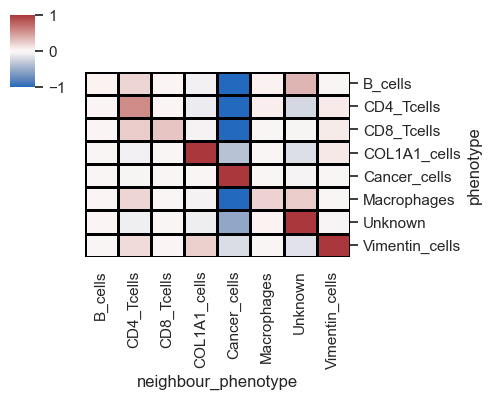

In [29]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_radius70',
                          linewidths=0.75, linecolor='black', figsize=(5,4))

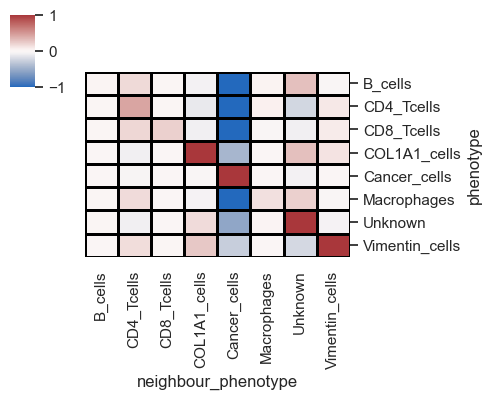

In [31]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_knn30',
                          linewidths=0.75, linecolor='black', figsize=(5,4))

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



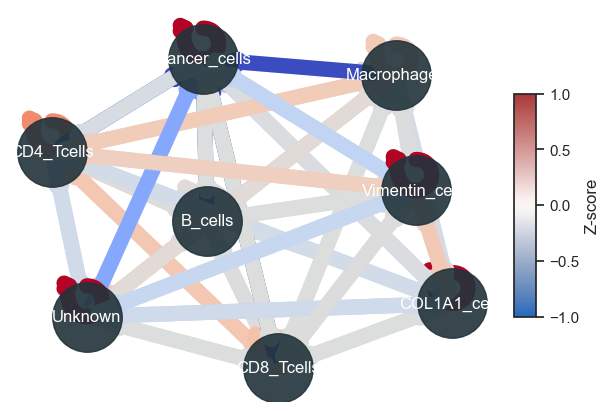

In [30]:
sm.pl.spatialInteractionNetwork(adata, spatial_interaction='spatial_interaction_radius70', figsize=(6,4))

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



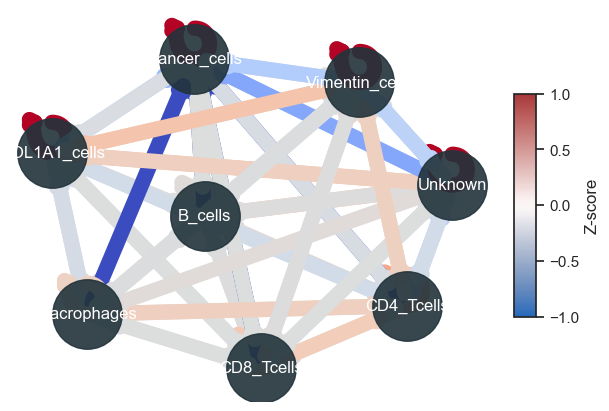

In [33]:
sm.pl.spatialInteractionNetwork(
    adata,
    spatial_interaction='spatial_interaction_knn30', 
    p_val=0.1,
    figsize=(6,4))

In [35]:
adata = ad.read_h5ad("../data/perSample/991/adata_checkpoints/8_spatial_interaction/20250519_1232_8_spatial_interaction_adata.h5ad")

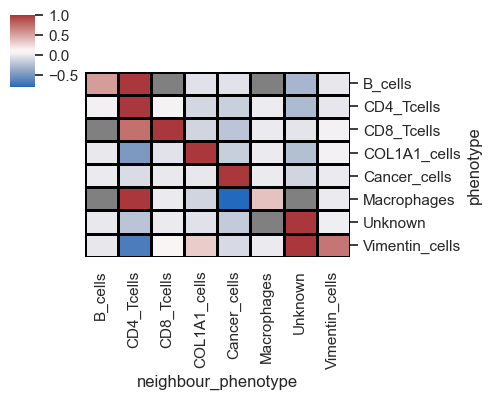

In [36]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_radius70',
                          linewidths=0.75, linecolor='black', figsize=(5,4))

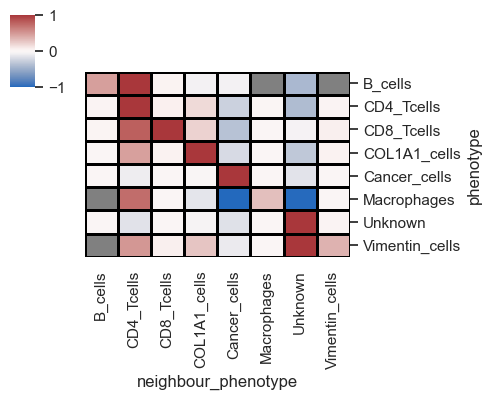

In [37]:
sm.pl.spatial_interaction(adata, 
                          spatial_interaction='spatial_interaction_knn30',
                          linewidths=0.75, linecolor='black', figsize=(5,4))

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



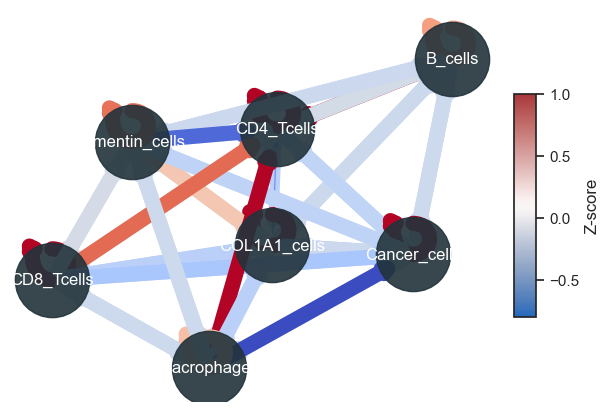

In [42]:
sm.pl.spatialInteractionNetwork(
    adata, spatial_interaction='spatial_interaction_radius70', figsize=(6,4),
    subsetPhenotype=['Cancer_cells', 'CD4_Tcells', 'CD8_Tcells', 'COL1A1_cells', 'Vimentin_cells', 'B_cells', 'Macrophages']
                                )

In [40]:
adata.obs.phenotype.unique()

['Cancer_cells', 'CD4_Tcells', 'CD8_Tcells', 'COL1A1_cells', 'Unknown', 'Vimentin_cells', 'B_cells', 'Macrophages']
Categories (8, object): ['B_cells', 'CD4_Tcells', 'CD8_Tcells', 'COL1A1_cells', 'Cancer_cells', 'Macrophages', 'Unknown', 'Vimentin_cells']

/opt/homebrew/Caskroom/mambaforge/base/envs/scimap_3/lib/python3.10/site-packages/scipy/stats/_stats_py.py:9694: RuntimeWarning:

divide by zero encountered in log



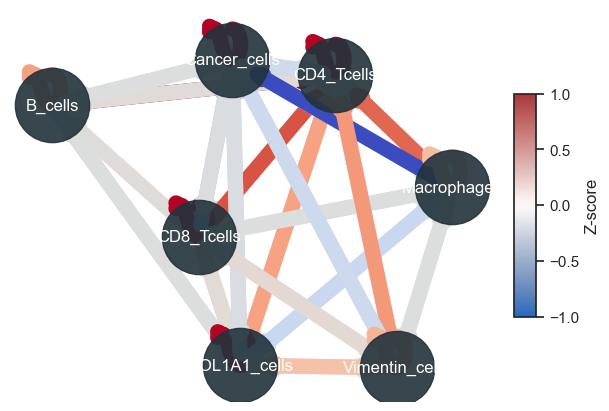

In [41]:
sm.pl.spatialInteractionNetwork(
    adata,
    spatial_interaction='spatial_interaction_knn30', 
    p_val=0.1,
    figsize=(6,4),
    subsetPhenotype=['Cancer_cells', 'CD4_Tcells', 'CD8_Tcells', 'COL1A1_cells', 'Vimentin_cells', 'B_cells', 'Macrophages'])

In [48]:
adata

AnnData object with n_obs × n_vars = 610182 × 8
    obs: 'CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity', '991', 'artefact', 'mean_DAPI_bg_above_100', 'mean_DAPI_bg_below_3162', 'Area_filter_nottoobig', 'Area_filter_nottoolow', 'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow', 'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid', 'phenotype'
    var: 'math', 'marker'
    uns: 'gates', 'spatial_interaction_knn30', 'spatial_interaction_radius70'
    layers: 'log'

In [49]:
adata.uns['spatial_interaction_knn30']

,phenotype,neighbour_phenotype,991,pvalue_991
0,B_cells,B_cells,0.463056,0.000000e+00
1,B_cells,CD4_Tcells,1.000000,0.000000e+00
2,B_cells,CD8_Tcells,0.036661,4.749480e-09
3,B_cells,COL1A1_cells,-0.066191,0.000000e+00
4,B_cells,Cancer_cells,-0.069888,0.000000e+00
...,...,...,...,...
59,Vimentin_cells,COL1A1_cells,0.266284,0.000000e+00
60,Vimentin_cells,Cancer_cells,-0.110534,0.000000e+00
61,Vimentin_cells,Macrophages,-0.000504,6.937678e-58
62,Vimentin_cells,Unknown,1.000000,0.000000e+00


In [50]:
df = adata.uns['spatial_interaction_knn30'].copy()

In [51]:
df[df['phenotype'] == "Macrophages"]

,phenotype,neighbour_phenotype,991,pvalue_991
40,Macrophages,B_cells,0.020612,5.660020e-01
41,Macrophages,CD4_Tcells,0.719886,2.510560e-59
42,Macrophages,CD8_Tcells,-0.001549,2.527055e-90
43,Macrophages,COL1A1_cells,-0.141308,1.990123e-68
44,Macrophages,Cancer_cells,-1.000000,1.251125e-35
45,Macrophages,Macrophages,0.302514,0.000000e+00
46,Macrophages,Unknown,-0.990468,2.729406e-48
47,Macrophages,Vimentin_cells,-0.005957,1.753849e-63


In [52]:
adata_991 = ad.read_h5ad("../data/perSample/991/adata_checkpoints/8_spatial_interaction/20250519_1232_8_spatial_interaction_adata.h5ad")
adata_992 = ad.read_h5ad("../data/perSample/992/adata_checkpoints/8_spatial_interaction/20250519_1312_8_spatial_interaction_adata.h5ad")

In [53]:
df_991 = adata_991.uns['spatial_interaction_knn30'].copy()
df_992 = adata_992.uns['spatial_interaction_knn30'].copy()

In [58]:
df_991[df_991['phenotype'] == "Cancer_cells"]

,phenotype,neighbour_phenotype,991,pvalue_991
32,Cancer_cells,B_cells,-0.000947,0.000000e+00
33,Cancer_cells,CD4_Tcells,-0.101527,0.000000e+00
34,Cancer_cells,CD8_Tcells,-0.008701,0.000000e+00
35,Cancer_cells,COL1A1_cells,-0.027709,0.000000e+00
36,Cancer_cells,Cancer_cells,1.000000,0.000000e+00
37,Cancer_cells,Macrophages,-0.001651,1.175544e-68
38,Cancer_cells,Unknown,-0.153988,0.000000e+00
39,Cancer_cells,Vimentin_cells,-0.002538,0.000000e+00


In [59]:
df_992[df_992['phenotype'] == "Cancer_cells"]

,phenotype,neighbour_phenotype,992,pvalue_992
32,Cancer_cells,B_cells,-0.000389,3.527635e-75
33,Cancer_cells,CD4_Tcells,-0.043065,0.000000e+00
34,Cancer_cells,CD8_Tcells,-0.002021,0.000000e+00
35,Cancer_cells,COL1A1_cells,-0.025841,0.000000e+00
36,Cancer_cells,Cancer_cells,1.000000,0.000000e+00
37,Cancer_cells,Macrophages,-0.014692,0.000000e+00
38,Cancer_cells,Unknown,-0.062752,0.000000e+00
39,Cancer_cells,Vimentin_cells,-0.007324,0.000000e+00


In [60]:
adata_both = ad.read_h5ad("../data/perSample/991_992/2_spatial_distance/20250411_1544_2_spatial_distance_adata.h5ad")

In [61]:
import numpy as np
import pandas as pd
from scipy.spatial import cKDTree
from collections import Counter

def compute_celltype_interactions(adata, distance_threshold=20, slide_key='slide', 
                                  celltype_key='celltype', x_key='X', y_key='Y'):
    """
    Computes the number of interactions between cell types within a distance threshold per slide.
    
    Parameters:
        adata: AnnData object with .obs containing celltype, slide ID, and X,Y coordinates
        distance_threshold: Distance (in same units as coordinates) to define interaction
        slide_key: Column in adata.obs that contains slide identifiers
        celltype_key: Column in adata.obs with cell type labels
        x_key, y_key: Columns in adata.obs with X and Y coordinates
        
    Returns:
        DataFrame with columns: slide, celltype_1, celltype_2, count
    """
    all_interactions = []

    for slide, obs_slide in adata.obs.groupby(slide_key):
        coords = obs_slide[[x_key, y_key]].values
        tree = cKDTree(coords)
        pairs = tree.query_pairs(distance_threshold)
        
        if not pairs:
            continue
        
        indices = obs_slide.index.to_list()
        celltypes = obs_slide[celltype_key].to_dict()
        
        pair_cts = [
            tuple(sorted((celltypes[indices[i]], celltypes[indices[j]])))
            for i, j in pairs
        ]
        
        counts = Counter(pair_cts)
        slide_df = pd.DataFrame([
            {'slide': slide, 'celltype_1': ct1, 'celltype_2': ct2, 'count': count}
            for (ct1, ct2), count in counts.items()
        ])
        
        all_interactions.append(slide_df)

    interaction_df = pd.concat(all_interactions, ignore_index=True)
    return interaction_df


In [62]:
adata_both.obs.columns

Index(['CellID', 'Y_centroid', 'X_centroid', 'Area', 'MajorAxisLength',
       'MinorAxisLength', 'Eccentricity', 'Orientation', 'Extent', 'Solidity',
       'artefact', 'Area_filter_nottoobig', 'Area_filter_nottoolow',
       'Area_filter', 'DAPI_ratio', 'DAPI_ratio_pass_nottoolow',
       'DAPI_ratio_pass_nottoohigh', 'DAPI_ratio_pass', 'filtering', 'imageid',
       'phenotype', 'cell_id', 'spatial_lda_knn7_kmeans_k7',
       'spatial_lda_knn14_kmeans_k7', 'spatial_lda_knn21_kmeans_k7',
       'spatial_lda_knn30_kmeans_k7', 'spatial_lda_knn40_kmeans_k7',
       'spatial_lda_knn50_kmeans_k7'],
      dtype='object')

In [64]:
df_interactions = compute_celltype_interactions(adata=adata_both, slide_key="imageid", 
                              celltype_key="phenotype", x_key="X_centroid", y_key="Y_centroid")

In [65]:
df_interactions

,slide,celltype_1,celltype_2,count
0,991,CD4_Tcells,Unknown,1092
1,991,B_cells,Unknown,55
2,991,CD4_Tcells,CD4_Tcells,4692
3,991,CD4_Tcells,CD8_Tcells,388
4,991,B_cells,B_cells,144
...,...,...,...,...
58,992,Macrophages,Vimentin_cells,4
59,992,B_cells,CD4_Tcells,2
60,992,CD8_Tcells,Vimentin_cells,1
61,992,B_cells,B_cells,1


<Axes: xlabel='celltype_2', ylabel='count'>

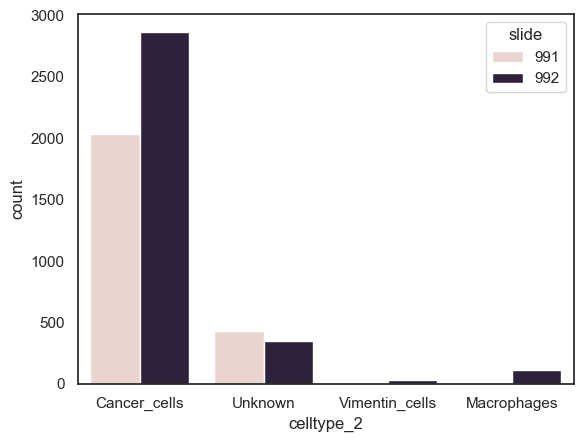

In [77]:
sns.barplot(data=df_interactions[df_interactions['celltype_1']=="Cancer_cells"], x="celltype_2", y="count", hue="slide")

In [70]:
df_interactions.slide.dtype

dtype('int64')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
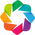

In [69]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

def plot_chord_diagram(interaction_df, slide):
    """
    Plots a chord diagram of cell type interactions for a given slide.

    Parameters:
        interaction_df: Output DataFrame from compute_celltype_interactions()
        slide: Slide identifier to visualize
    """
    df = interaction_df[interaction_df['slide'] == slide].copy()
    
    if df.empty:
        print(f"No interactions found for slide '{slide}'")
        return
    
    # Create edges: (source, target, value)
    edges = [(row['celltype_1'], row['celltype_2'], row['count']) for _, row in df.iterrows()]
    
    # Unique cell types
    nodes = pd.DataFrame({'name': pd.unique(df[['celltype_1', 'celltype_2']].values.ravel())})
    
    chord = hv.Chord((edges, hv.Dataset(nodes, 'name')))
    chord.opts(
        opts.Chord(
            labels='name',
            edge_color='source',
            node_color='name',
            cmap='Category20',
            width=600,
            height=600,
            title=f"Cell Type Interactions on Slide: {slide}",
        )
    )
    return chord


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
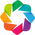

In [78]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

def plot_chord_diagram(interaction_df, slide):
    """
    Plots a chord diagram of cell type interactions for a given slide, with edge thickness
    scaled by number of interactions.
    
    Parameters:
        interaction_df: Output DataFrame from compute_celltype_interactions()
        slide: Slide identifier to visualize
    """
    df = interaction_df[interaction_df['slide'] == slide].copy()
    
    if df.empty:
        print(f"No interactions found for slide '{slide}'")
        return
    
    # Rename columns to fit holoviews expected format
    df = df.rename(columns={
        'celltype_1': 'source',
        'celltype_2': 'target',
        'count': 'value'
    })

    # Create edge list
    edges = df[['source', 'target', 'value']]
    
    # Get all unique nodes
    nodes = pd.DataFrame({'name': pd.unique(edges[['source', 'target']].values.ravel())})
    
    chord = hv.Chord((edges, hv.Dataset(nodes, 'name')))
    chord.opts(
        opts.Chord(
            labels='name',
            edge_color='source',
            node_color='name',
            cmap='Category20',
            width=600,
            height=600,
            title=f"Cell Type Interactions on Slide: {slide}",
            edge_line_width=hv.dim('value') * 0.05  # Scale edge thickness by value
        )
    )
    return chord


In [68]:
!pip install holoviews

  Using cached colorcet-3.1.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached param-2.2.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached linkify_it_py-2.0.3-py3-none-any.whl.metadata (8.5 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
  Using cached uc_micro_py-1.0.3-py3-none-any.whl.metadata (2.0 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 51.2 MB/s eta 0:00:00
Using cached param-2.2.0-py3-none-any.whl (119 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 53.3 MB/s eta 0:00:00a 0:00:01
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached colorcet-3.1.0-py3-none-any.whl (260 kB)
Using cached linkify_it_py-2.0.3-py3-none-any.whl (19 kB)
Using cach

In [82]:
plot_chord_diagram(df_interactions, slide=991)

:Chord   [source,target]   (value)

In [81]:
plot_chord_diagram(df_interactions, slide=992)

:Chord   [source,target]   (value)